<a href="https://colab.research.google.com/github/KatBCN/MUD-Lab-LangDet/blob/main/Assignment1_MUD_KW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mining Unstructured Data - Lab 1

## Introduction

Studying the impact of different processing techniques on NLP task.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install utils
from utils import *

In [ ]:
import argparse
import numpy as np
import nltk
import matplotlib.pyplot as plt
import pandas as pd
import random
import scipy
import seaborn as sn


from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import normalize
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.decomposition import PCA

from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split


In [ ]:
#preprocess

#Tokenizer function. You can add here different preprocesses.
def preprocess(sentence, labels):
    '''
    Task: Given a sentence apply all the required preprocessing steps
    to compute train our classifier, such as sentence splitting, 
    tokenization or sentence splitting.

    Input: Sentence in string format
    Output: Preprocessed sentence either as a list or a string
    '''
    # Place your code here
    # Keep in mind that sentence splitting affectes the number of sentences
    # and therefore, you should replicate labels to match.
    return sentence,labels

In [ ]:
# classifiers

# You may add more classifier methods replicating this function
def applyNaiveBayes(X_train, y_train, X_test):
    '''
    Task: Given some features train a Naive Bayes classifier
          and return its predictions over a test set
    Input; X_train -> Train features
           y_train -> Train_labels
           X_test -> Test features 
    Output: y_predict -> Predictions over the test set
    '''
    trainArray = toNumpyArray(X_train)
    testArray = toNumpyArray(X_test)
    
    clf = MultinomialNB()
    clf.fit(trainArray, y_train)
    y_predict = clf.predict(testArray)
    return y_predict

In [ ]:
# utils

def compute_features(X_train, 
                     X_test, 
                     analyzer='char', 
                     max_features=None):
  '''
  Task: Compute a matrix of token counts given a corpus. 
        This matrix represents the frecuency any pair of tokens appears
        together in a sentence.
 
  Input: X_train -> Train sentences
         X_test -> Test sentences
         analyzer -> Granularity used to process the sentence 
                    Values: {word, char}
         tokenizer -> Callable function to apply to the sentences before compute.
  
  Output: unigramFeatures: Cout matrix
          X_unigram_train_raw: Features computed for the Train sentences
          X_unigram_test_raw: Features computed for the Test sentences 
  '''
  
  unigramVectorizer = CountVectorizer(analyzer=analyzer,
                                      max_features=max_features,
                                      ngram_range=(1,1))
  
  X_unigram_train_raw = unigramVectorizer.fit_transform(X_train)
  X_unigram_test_raw = unigramVectorizer.transform(X_test)
  unigramFeatures = unigramVectorizer.get_feature_names()
  return unigramFeatures, X_unigram_train_raw, X_unigram_test_raw
    


def compute_coverage(features, split, analyzer='char'):
  '''
  Task: Compute the proportion of a corpus that is represented by
        the vocabulary. All non covered tokens will be considered as unknown
        by the classifier.
  
  Input: features -> Count matrix
         split -> Set of sentence 
         analyzer -> Granularity level {'word', 'char'}
  
  Output: proportion of covered tokens
  '''
  total = 0.0
  found = 0.0
  for sent in split:
    #The following may be affected by your preprocess function. Modify accordingly
    sent = sent.split(' ') if analyzer == 'word' else list(sent)
    total += len(sent)
    for token in sent:
      if token in features:
        found += 1.0
  return found / total

# Utils for conversion of different sources into numpy array
def toNumpyArray(data):
    '''
    Task: Cast different types into numpy.ndarray
    Input: data ->  ArrayLike object
    Output: numpy.ndarray object
    '''
    data_type = type(data)
    if data_type == np.ndarray:
        return data
    elif data_type == list:
        return np.array(data_type)
    elif data_type == scipy.sparse.csr.csr_matrix:
        return data.toarray()
    print(data_type)
    return None    
  
def normalizeData(train, test):
    '''
    Task: Normalize data to train classifiers. This process prevents errors
          due to features with different scale
    
    Input: train -> Train features
           test -> Test features

    Output: train_result -> Normalized train features
            test_result -> Normalized test features
    '''
    train_result = normalize(train, norm='l2', axis=1, copy=True, return_norm=False)
    test_result = normalize(test, norm='l2', axis=1, copy=True, return_norm=False)
    return train_result, test_result


def plot_F_Scores(y_test, y_predict):
    '''
    Task: Compute the F1 score of a set of predictions given
          its reference

    Input: y_test: Reference labels 
           y_predict: Predicted labels

    Output: Print F1 score
    '''
    f1_micro = f1_score(y_test, y_predict, average='micro')
    f1_macro = f1_score(y_test, y_predict, average='macro')
    f1_weighted = f1_score(y_test, y_predict, average='weighted')
    print("F1: {} (micro), {} (macro), {} (weighted)".format(f1_micro, f1_macro, f1_weighted))

def plot_Confusion_Matrix(y_test, y_predict):
    cmap = sn.diverging_palette(250, 15, s=75, l=40,n=9, center="dark")
    '''
    Task: Given a set of reference and predicted labels plot its confussion matrix
    
    Input: y_test ->  Reference labels
           y_predict -> Predicted labels
           color -> [Optional] Color used for the plot
    
    Ouput: Confussion Matrix plot
    '''
    allLabels = list(set(list(y_test) + list(y_predict)))
    allLabels.sort()
    confusionMatrix = confusion_matrix(y_test, y_predict, labels=allLabels)
    unqiueLabel = np.unique(allLabels)
    df_cm = pd.DataFrame(confusionMatrix, columns=unqiueLabel, index=unqiueLabel)
    df_cm.index.name = 'Actual'
    df_cm.columns.name = 'Predicted'
    sn.set(font_scale=0.8) # for label size
    sn.set(rc={'figure.figsize':(15, 15)})
    sn.heatmap(df_cm, cmap=cmap, annot=True, annot_kws={"size": 12}, fmt='g', linewidth=0.3, cbar_kws={"shrink": .8})# font size
    plt.show()


def plotPCA(x_train, x_test,y_test, langs):
    '''
    Task: Given train features train a PCA dimensionality reduction
          (2 dimensions) and plot the test set according to its labels.
    
    Input: x_train -> Train features
           x_test -> Test features
           y_test -> Test labels
           langs -> Set of language labels

    Output: Print the amount of variance explained by the 2 first principal components.
            Plot PCA results by language
            
    '''
    pca = PCA(n_components=2)
    pca.fit(toNumpyArray(x_train))
    pca_test = pca.transform(toNumpyArray(x_test))
    print('Variance explained by PCA:', pca.explained_variance_ratio_)
    y_test_list = np.asarray(y_test.tolist())
    for lang in langs:
        pca_x = np.asarray([i[0] for i in pca_test])[y_test_list == lang]
        pca_y = np.asarray([i[1] for i in pca_test])[y_test_list == lang]
        plt.scatter(pca_x,pca_y, label=lang)
    plt.legend(loc="upper left")
    plt.show()


In [ ]:
# langdetect
seed = 42
random.seed(seed)


def get_parser():
    parser = argparse.ArgumentParser()
    parser.add_argument("-i", "--input", 
                        help="Input data in csv format", type=str)
    parser.add_argument("-v", "--voc_size", 
                        help="Vocabulary size", type=int)
    parser.add_argument("-a", "--analyzer",
                         help="Tokenization level: {word, char}", 
                        type=str, choices=['word','char'])
    return parser


def results (input, vocabulary, analyzer):
    #parser = get_parser()
    #args = parser.parse_args()
    raw = pd.read_csv(input)
    
    # Languages
    languages = set(raw['language'])
    print('========')
    print('Languages', languages)
    print('========')

    # Split Train and Test sets
    X=raw['Text']
    y=raw['language']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)
    
    print('========')
    print('Split sizes:')
    print('Train:', len(X_train))
    print('Test:', len(X_test))
    print('========')
    
    # Preprocess text (Word granularity only)
    if analyzer == 'word':
        X_train, y_train = preprocess(X_train,y_train)
        X_test, y_test = preprocess(X_test,y_test)

    #Compute text features
    features, X_train_raw, X_test_raw = compute_features(X_train, 
                                                            X_test, 
                                                            analyzer=analyzer, 
                                                            max_features=vocabulary)

    print('========')
    print('Number of tokens in the vocabulary:', len(features))
    print('Coverage: ', compute_coverage(features, X_test.values, analyzer=analyzer))
    print('========')


    #Apply Classifier  
    X_train, X_test = normalizeData(X_train_raw, X_test_raw)
    y_predict = applyNaiveBayes(X_train, y_train, X_test)
    
    print('========')
    print('Prediction Results:')    
    plot_F_Scores(y_test, y_predict)
    print('========')
    
    plot_Confusion_Matrix(y_test, y_predict) 


    #Plot PCA
    print('========')
    print('PCA and Explained Variance:') 
    plotPCA(X_train, X_test,y_test, languages) 
    print('========')

# Data Exploration

In [ ]:
path = '/content/drive/MyDrive/MUD-Lab1/dataset.csv'

In [ ]:
input = path

The data consists of many rows with two columns. The first column is a sample text, and the second column is the label for the language of the text in the first column.

In [ ]:
data = pd.read_csv(input)
data.head()

,Text,language
0,klement gottwaldi surnukeha palsameeriti ning ...,Estonian
1,sebes joseph pereira thomas på eng the jesuit...,Swedish
2,ถนนเจริญกรุง อักษรโรมัน thanon charoen krung เ...,Thai
3,விசாகப்பட்டினம் தமிழ்ச்சங்கத்தை இந்துப் பத்திர...,Tamil
4,de spons behoort tot het geslacht haliclona en...,Dutch


In [ ]:
# size of data set
data.shape

(22000, 2)

In [ ]:
# number of samples per lanugage
data.language.value_counts()

Estonian      1000
Swedish       1000
English       1000
Russian       1000
Romanian      1000
Persian       1000
Pushto        1000
Spanish       1000
Hindi         1000
Korean        1000
Chinese       1000
French        1000
Portugese     1000
Indonesian    1000
Urdu          1000
Latin         1000
Turkish       1000
Japanese      1000
Dutch         1000
Tamil         1000
Thai          1000
Arabic        1000
Name: language, dtype: int64

There are 22 languages in the data set. Each language has 1000 samples inlcuded.

In [ ]:
# number of unique languages
len(data.language.unique())

22

Some samples contain sentences which contain words from mulitple languages, as seen in the Urdu example below with English words. The Thai example also contains a mix of words written in Thai and Latin scripts.

From the samples below, we can see that at least eleven languages (half of the data set) use characters based on [latin script](https://en.wikipedia.org/wiki/Latin_script):


1. Estonian
2. Swedish
3. Dutch
4. Turkish
5. Latin
6. Indonesian
7. Portugese
8. French
9. Spanish
10. Romanian
11. English

Four languages use characters based on [arabic script](https://en.wikipedia.org/wiki/Arabic_script):

1. Urdu
2. Pushto
3. Persian
4. Arabic

Seven languages appear to have unique scripts, character sets, or writing systems.

1. [Thai](https://en.wikipedia.org/wiki/Thai_script)
2. [Tamil](https://en.wikipedia.org/wiki/Tamil_script)
3. [Japanese](https://en.wikipedia.org/wiki/Japanese_writing_system)
4. [Chinese](https://en.wikipedia.org/wiki/Chinese_characters)
5. [Korean](https://en.wikipedia.org/wiki/Hangul)
6. [Hindi](https://en.wikipedia.org/wiki/Devanagari)
7. [Russian](https://en.wikipedia.org/wiki/Russian_alphabet)


In [ ]:
# show one row for each language
grouped = data.groupby('language')
grouped.head(1)

# Tokenizing with chars

* Experiment 1: size of vocabulary 1000

Languages {'Tamil', 'English', 'Dutch', 'Latin', 'Arabic', 'Thai', 'Japanese', 'Pushto', 'Estonian', 'Portugese', 'Korean', 'Indonesian', 'Urdu', 'Persian', 'Swedish', 'Turkish', 'Romanian', 'Russian', 'French', 'Spanish', 'Chinese', 'Hindi'}
Split sizes:
Train: 17600
Test: 4400


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Number of tokens in the vocabulary: 1000
Coverage:  0.9808517331929401
Prediction Results:
F1: 0.9552272727272727 (micro), 0.9578334706797794 (macro), 0.9574109803676452 (weighted)


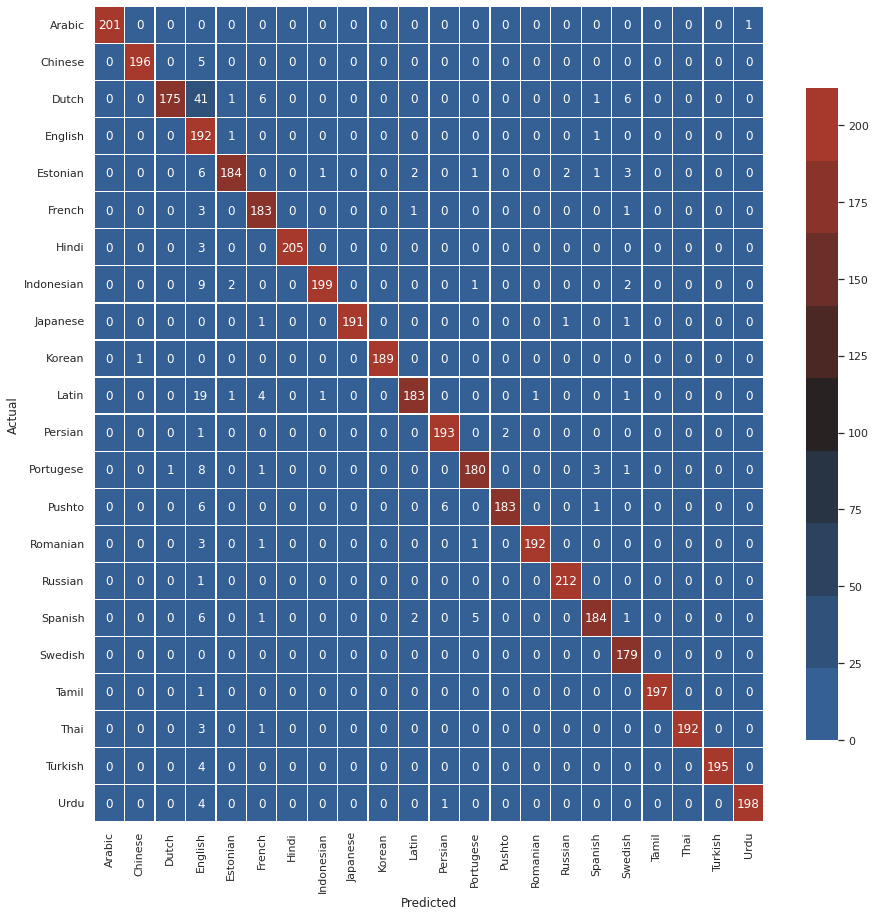

PCA and Explained Variance:
Variance explained by PCA: [0.3131436  0.13806745]


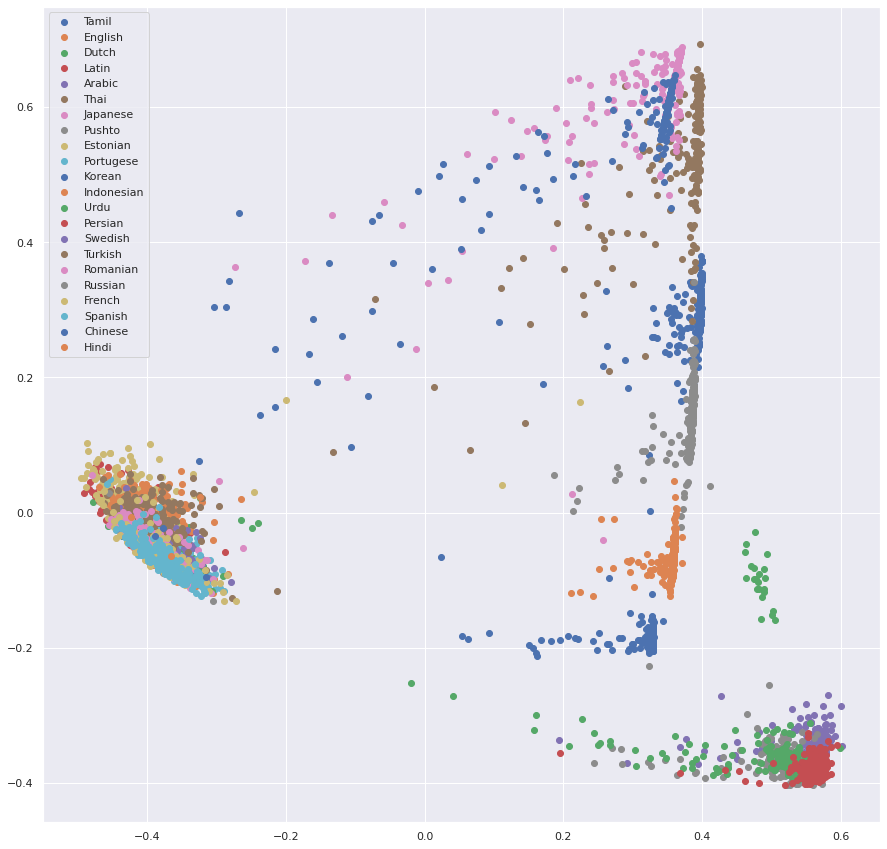

In [ ]:
vocabulary = 1000
analyzer = 'char'
results(input, vocabulary, analyzer)

* Experiment 2: 

* Experiment 2: size of vocabulary 500

In [ ]:
vocabulary = 500
analyzer = 'char'
results(input, vocabulary, analyzer)

* Experiment 2: size of vocabulary 500

In [ ]:
vocabulary = 2000
analyzer = 'word'
results(input, vocabulary, analyzer)

In [ ]:
input = '/content/dataset.csv'
vocabulary = 14000
analyzer = 'char'
results(input, vocabulary, analyzer)

**-How well does the vocabulary covers the data?**

Depending on the token (char, word) the size of the vocabulary presents 

**-Which languages produce more errors, what do they have in common (family, script, etc)?**

After the experiments observed, for this data set, Dutch and chinese languages tend to present higher number of errors in words and chars classified correctly no matter the size of vocabulary. 


**-How languages overlap on the PCA plot? What could that
overlapping mean?**

**Preprocess**

**Code**

**Experiments and results**

**Conclusions**